In [1]:
import vamtoolbox as vam
import numpy as np
import os

import time

# settings

dimension = [128, 128] #2560 1600
OutputFolder = "./ImageSeq"
InputFolder = "./STLfiles/"
PreProjectionFolder = "./preProjectionSeq"
OutputPrefix = "Target"
name = "/1/2020.stl"
singleFile = False
num_angles = 360
n_iter  = 20
d_h = 0.85
d_l = 0.6
filterType = 'hamming' #ramlak
method = 'OSMO'
resolution = dimension[1]

start_time = time.time()


c:\Users\Mark\anaconda3\envs\ModifiedCALenv\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


In [2]:
# calcualted settings

optimizer_params = vam.optimize.Options(method=method, n_iter=n_iter, d_h = d_h, d_l = d_l, filter=filterType)
angles = np.linspace(0, 360 - 360/num_angles, num_angles)
iconfig0=vam.imagesequence.ImageConfig(image_dims=(dimension[0],dimension[1]),array_offset=0)

In [3]:
# path sanity check

STL_folders = os.listdir(InputFolder)
print(STL_folders)

# clear all output image sequences FOR TESTING PURPOSES
# DELETE THIS WHEN DOING A REAL DATA GENERATION RUN
for f in os.listdir(OutputFolder):
    os.remove(os.path.join(OutputFolder, f))

# clear all output image sequences FOR TESTING PURPOSES
# DELETE THIS WHEN DOING A REAL DATA GENERATION RUN
for f in os.listdir(PreProjectionFolder):
    os.remove(os.path.join(PreProjectionFolder, f))

['thinker_mod.stl']


In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2


def scale_to_fit(image_normalized, desired_height, desired_width):
    # Calculate the aspect ratio of the original image
    original_height, original_width = image_normalized.shape
    original_aspect_ratio = original_width / original_height
    desired_aspect_ratio = desired_width / desired_height

    if original_aspect_ratio > desired_aspect_ratio:
        # scale image_normalized so that the width = desired_width
        scaled_width = desired_width
        scaled_height = int(desired_width / original_aspect_ratio)
        scaled_image = cv2.resize(image_normalized, (scaled_width, scaled_height))
        buffer_image = np.zeros((desired_height, desired_width))
        start_y = (desired_height - scaled_height) // 2
        buffer_image[start_y:start_y+scaled_height, :] = scaled_image
    else:
        # scale image_normalized so that the height = desired_height
        scaled_height = desired_height
        scaled_width = int(desired_height * original_aspect_ratio)
        scaled_image = cv2.resize(image_normalized, (scaled_width, scaled_height))
        buffer_image = np.zeros((desired_height, desired_width))
        start_x = (desired_width - scaled_width) // 2
        buffer_image[:, start_x:start_x+scaled_width] = scaled_image
    return buffer_image


def saveProjections(b, save_dir: str, image_prefix: str = "image", image_type: str = ".png"):
    for k in range(len(b[0, :, 0])):
        save_path = os.path.join(save_dir, f"{image_prefix}{str(k).zfill(4)}{image_type}")
        print(f"save path = {save_path}")
        image = b[:, k, :]

        # Normalize the pixel values to the range [0, 255]
        image_normalized = (image - image.min()) * (255.0 / (image.max() - image.min()))

        # Calculate the desired dimensions with black buffer
        desired_height = dimension[0]
        desired_width = dimension[1]

        buffer_image = scale_to_fit(image_normalized, desired_height, desired_width)

        # Convert to integer type and create the image
        buffer_image = buffer_image.astype(np.uint8)
        im = Image.fromarray(buffer_image)

        im.save(save_path, subsampling=0, quality=100)
        # print(f"Saving image {str(k).zfill(4)}/{str(len(b[0])).zfill(4)}")










In [5]:
import gc

class Options:

    __default_FBP = {"offset":False}
    __default_CAL = {"learning_rate":0.01,"momentum":0,"positivity":0,"sigmoid":0.01}
    __default_PM = {"rho_1":1,"rho_2":1,"p":1}
    __default_OSMO = {"inhibition":0}

    def __init__(self,method : str ='CAL',n_iter : int = 50,d_h : float = 0.8,d_l : float = 0.7,filter : str ='ram-lak',units:str='normalized',**kwargs):
        """
        Parameters
        ----------

        method : str
            Type of VAM method
                - "FBP"
                - "CAL"
                - "PM"
                - "OSMO"
        
        n_iter : int
            number of iterations to perform

        d_h : float
            in-target dose constraint

        d_l : float
            out-of-target dose constraint

        filter : str
            filter for initialization ("ram-lak", "shepp-logan", "cosine", "hamming", "hanning", None)

        learning_rate : float, optional (CAL)
            step size in approximate gradient descent
        
        momentum : float, optional (CAL)
            descent momentum for faster convergence

        positivity : float, optional (CAL)
            positivity constraint enforced at each iteration
        
        sigmoid : float, optional (CAL)
            sigmoid thresholding strength
        
        rho_1 : float, optional (PM)

        rho_2 : float, optional (PM)

        p : int, optional (PM)

        inhibition : float, optional (OSMO)




        """
        self.method = method
        self.n_iter = n_iter
        self.d_h = d_h
        self.d_l = d_l
        self.filter = filter
        self.units = units
        self.__default_FBP.update(kwargs)
        self.__default_CAL.update(kwargs)
        self.__default_PM.update(kwargs)
        self.__default_OSMO.update(kwargs)
        self.__dict__.update(kwargs)  # Store all the extra variables

        self.verbose = self.__dict__.get('verbose',False)
        self.bit_depth = self.__dict__.get('bit_depth',None)
        self.exit_param = self.__dict__.get('exit_param',None)

        if method == "FBP":
            self.offset = self.__default_FBP["offset"]

        if method == "CAL":
            self.learning_rate = self.__default_CAL["learning_rate"]
            self.momentum = self.__default_CAL["momentum"]
            self.positivity = self.__default_CAL["positivity"]
            self.sigmoid = self.__default_CAL["sigmoid"]

        if method == "PM":
            self.rho_1 = self.__default_PM["rho_1"]
            self.rho_2 = self.__default_PM["rho_2"]    
            self.p = self.__default_PM["p"]        

        if method == "OSMO":
            self.inhibition = self.__default_OSMO["inhibition"]

def returnPreOptimize(target_geo : vam.geometry.TargetGeometry,proj_geo : vam.geometry.ProjectionGeometry,options:Options):
    if options.units != "normalized" or proj_geo.absorption_coeff is not None:
        proj_geo.calcAbsorptionMask(target_geo)

    if options.method == "OSMO":
        A = vam.projectorconstructor.projectorconstructor(target_geo,proj_geo)
        
        # the first model is just the target
        x_model = np.copy(target_geo.array) 



        target_filtered = vam.util.data.filterTargetOSMO(target_geo.array,options.filter)
        x_model = np.real(target_filtered)

        # the initial sinogram is just the forward projection of the model
        b = A.forward(x_model)
        b = np.clip(b,0,None)
        # x = A.backward(b)
        # x = x/np.amax(x)
        return b
    
def generatedata(dir_list):
    for i in range(len(dir_list)):
        print("optimizing: " + dir_list[i])
        targetgeo = vam.geometry.TargetGeometry(stlfilename=dir_list[i], resolution=resolution)
        
        # targetgeo.show()

        # Set output name to match the STL input file
        OutputPrefix = os.path.splitext(os.path.split(dir_list[i])[1])[0]
        print(os.path.split(dir_list[i]))

        # Can we put this in calculated settings?
        proj_geo = vam.geometry.ProjectionGeometry(angles, ray_type='parallel', CUDA=True)

        b = returnPreOptimize(targetgeo, proj_geo, optimizer_params)
        opt_sino, opt_recon, error = vam.optimize.optimize(targetgeo, proj_geo, optimizer_params)

        opt_sino.show()
        opt_recon.show()
        slice_2d = b[:, 180, :].T  # Selecting the first 100 rows from the second dimension
        plt.imshow(slice_2d)
        plt.colorbar()  # Optional: Add a colorbar to the plot
        plt.show()

        # Resize opt_sino.array with black buffer
        desired_height = dimension[0]
        desired_width = dimension[1]
        
        # Save images
        print("output folder:", OutputFolder)
        print("output prefix:", OutputPrefix)
        saveProjections(b, save_dir=OutputFolder, image_prefix=OutputPrefix)
        saveProjections(opt_sino.array, save_dir=PreProjectionFolder, image_prefix=OutputPrefix)
        # print("sino size:" + str(opt_sino.array.shape))
        del targetgeo
        del proj_geo
        del b
        del opt_sino
        del opt_recon
        del slice_2d
        gc.collect()


In [6]:
#Cell to run if you just want to get unoptimized sinogram for a single STL file. If not, set singleFile to False

if singleFile:
    file = InputFolder + name
    files = []
    files.append(file)
    print("Generating data for", files)
    generatedata(files)

Generating data for 1 ['./STLfiles/thinker_mod.stl']
optimizing: ./STLfiles/thinker_mod.stl
('./STLfiles', 'thinker_mod.stl')


c:\Users\Mark\anaconda3\envs\ModifiedCALenv\lib\site-packages\vamtoolbox\util\data.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  return x_filtered.astype(float)


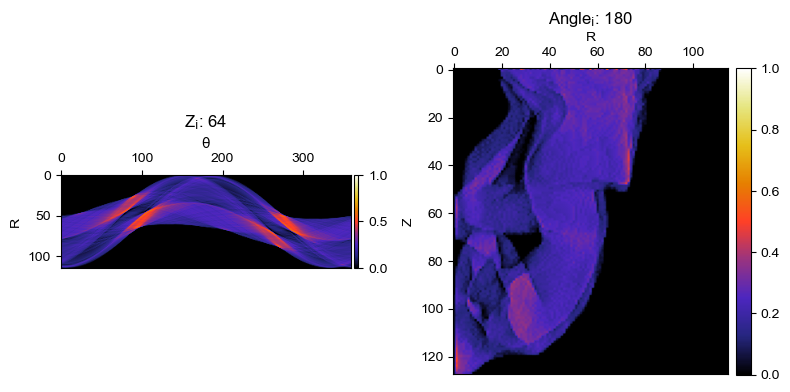

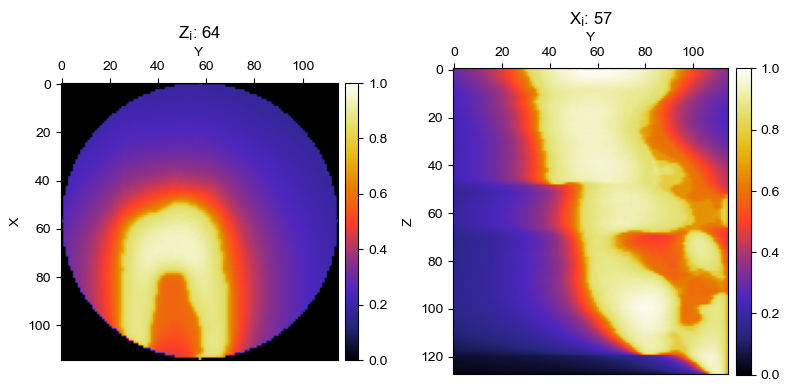

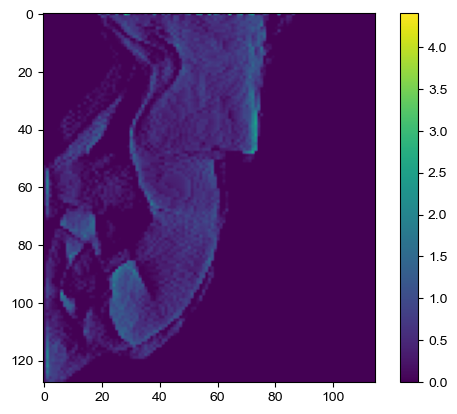

output folder: ./ImageSeq
output prefix: thinker_mod
save path = ./ImageSeq\thinker_mod0000.png
save path = ./ImageSeq\thinker_mod0001.png
save path = ./ImageSeq\thinker_mod0002.png
save path = ./ImageSeq\thinker_mod0003.png
save path = ./ImageSeq\thinker_mod0004.png
save path = ./ImageSeq\thinker_mod0005.png
save path = ./ImageSeq\thinker_mod0006.png
save path = ./ImageSeq\thinker_mod0007.png
save path = ./ImageSeq\thinker_mod0008.png
save path = ./ImageSeq\thinker_mod0009.png
save path = ./ImageSeq\thinker_mod0010.png
save path = ./ImageSeq\thinker_mod0011.png
save path = ./ImageSeq\thinker_mod0012.png
save path = ./ImageSeq\thinker_mod0013.png
save path = ./ImageSeq\thinker_mod0014.png
save path = ./ImageSeq\thinker_mod0015.png
save path = ./ImageSeq\thinker_mod0016.png
save path = ./ImageSeq\thinker_mod0017.png
save path = ./ImageSeq\thinker_mod0018.png
save path = ./ImageSeq\thinker_mod0019.png
save path = ./ImageSeq\thinker_mod0020.png
save path = ./ImageSeq\thinker_mod0021.png
s

In [7]:


# List all files in the folder with the ".stl" extension
files = []
for file in os.listdir(InputFolder):
    file_path = os.path.join(InputFolder, file)
    
    # Normalize the file path to ensure consistent forward slashes
    # file_path = os.path.normpath(file_path)
    
    if file.endswith('.stl') and os.path.isfile(file_path):
        files.append(file_path)

print(f"Generating data for {len(files)} {files}")
generatedata(files)
    
    
end_time = time.time()
print(end_time-start_time)